# (iv) Ridge regression (MASS: lm.ridge, mda: gen.ridge)
reference: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html



In [1]:
import pandas as pd
import re   #Regular expression operations
data_local = pd.read_csv('C:/Users/tianh/Dropbox (GaTech)/7406 Python code/prostate.csv', sep = (r'(?:,|;|\s)\s*'), header =0) #pay attention to the split criteria
data_local.head()

C:\Users\tianh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [2]:
prostate_train = data_local[data_local['train'] == 'T']
prostate_test = data_local[data_local['train'] == 'F']

In [3]:
y = prostate_train['lpsa']
X = prostate_train.drop(columns=['lpsa','train'])

In [27]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the sklearn package in order to perform ridge regression and the lasso. The main functions in this package that we care about are Ridge(), which can be used to fit ridge regression models, and Lasso() which will fit lasso models. They also have cross-validated counterparts: RidgeCV() and LassoCV().

# Ridge Regression

The Ridge() function has an alpha argument ( λ , but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [28]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [46]:
# ridge = Ridge() 
ridge = Ridge(normalize = True) 
#Remember that we'll want to standardize the variables 
#so that they are on the same scale. 
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 8)

We expect the coefficient estimates to be much smaller, in terms of  l2  norm, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

Text(0, 0.5, 'weights')

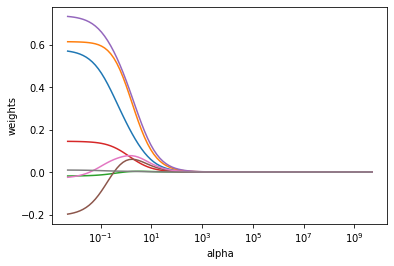

In [47]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso:m

In [48]:
# Split data into training and test sets
# y = prostate_train['lpsa']
# X = prostate_train.drop(columns=['lpsa','train'])
y_test = prostate_test['lpsa']
X_test = prostate_test.drop(columns=['lpsa','train'])

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  λ=4 :

In [49]:
ridge2 = Ridge(alpha = 4, normalize = True) #you can try different lambda here
ridge2.fit(X, y)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

lcavol     0.110768
lweight    0.200368
age        0.003452
lbph       0.038252
svi        0.230958
lcp        0.049971
gleason    0.064200
pgg45      0.002284
dtype: float64
0.6753729908557915


Instead of arbitrarily choosing alpha  =4 , it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV(). By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument cv.

In [50]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X, y)
ridgecv.alpha_

0.06164233697210317

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.0616. What is the test MSE associated with this value of alpha?

In [51]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X, y)
mean_squared_error(y_test, ridge4.predict(X_test))

0.49664016702116126

This represents a further improvement over the test MSE that we got using alpha  =4 . Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [54]:
y_all = data_local['lpsa']
X_all = data_local.drop(columns=['lpsa','train'])

ridge4.fit(X_all, y_all)
pd.Series(ridge4.coef_, index = X_all.columns)

lcavol     0.501822
lweight    0.607324
age       -0.017341
lbph       0.087312
svi        0.695596
lcp       -0.047875
gleason    0.062267
pgg45      0.003522
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not perform variable selection!

# The LASSO

We saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we'll use the Lasso() function; however, this time we'll need to include the argument max_iter = 10000. Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

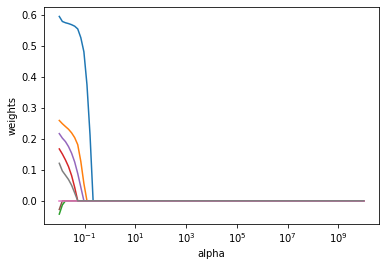

In [56]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_) #100X8
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [63]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X, y)

lasso.set_params(alpha=lassocv.alpha_)

print(lassocv.alpha_)
lasso.fit(X, y)
mean_squared_error(y_test, lasso.predict(X_test))

0.0004983782162878229


0.5097420219700463

In [67]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

lcavol     0.565257
lweight    0.611246
age       -0.018029
lbph       0.141552
svi        0.718820
lcp       -0.187142
gleason   -0.005113
pgg45      0.008559
dtype: float64

# 6.7.1 Principal Components Regression

reference: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html

In [72]:
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

Unfortunately sklearn does not have an implementation of PCA and regression combined like the pls, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [69]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

In [70]:
#Let's print out the first few variables of the first few principal components:
pd.DataFrame(pca.components_.T).loc[:4, :5]

,0,1,2,3,4,5
0,0.435996,0.032275,-0.284751,-0.054618,-0.397760,0.635888
1,0.167580,0.564694,-0.389996,0.011879,0.691914,0.134341
2,0.240921,0.419865,0.366343,-0.753355,-0.151798,-0.120633
3,0.030361,0.650263,0.061910,0.539180,-0.462219,-0.260499
4,0.395732,-0.175486,-0.421528,-0.139789,-0.070406,-0.672468


### CV
Now we'll perform 10-fold cross-validation to see how it influences the MSE:

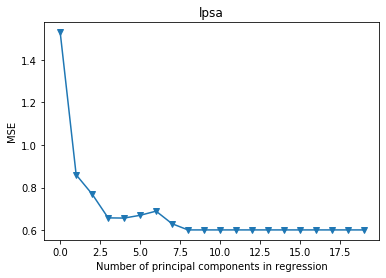

In [74]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('lpsa')
plt.xlim(xmin=-1);

In [75]:
#We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 42.83,  63.24,  76.2 ,  83.93,  89.62,  94.33,  97.83, 100.01])

Now let's perform PCA on the training data and evaluate its test set performance:

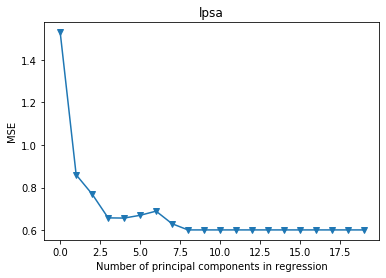

In [77]:
pca2 = PCA()

# Split into training and test sets
# X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('lpsa')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when  M=6  components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [78]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

0.6316748927443808

This test set MSE is competitive with the results obtained using ridge regression and the lasso. However, as a result of the way PCR is implemented, the final model is more difficult to interpret because it does not perform any kind of variable selection or even directly produce coefficient estimates.

# 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using method='oscorespls'. However, the standard method used is 'kernelpls', which we'll use here. Feel free to try out both.


(-1, 8.35)

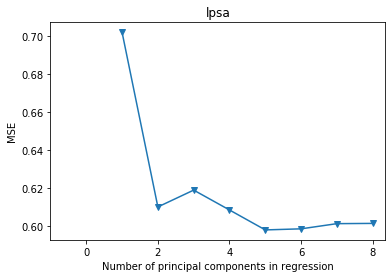

In [82]:
n = len(X)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 9):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X), y, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 9), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('lpsa')
plt.xlim(xmin=-1)

The lowest cross-validation error occurs when only  M=6  partial least squares dimensions are used. We now evaluate the corresponding test set MSE:

In [85]:
pls = PLSRegression(n_components=6)
pls.fit(scale(X), y)

mean_squared_error(y_test, pls.predict(scale(X_test)))

0.533068505848284

In [ ]:
The test MSE is again comparable to the test MSE obtained using ridge regression, the lasso, and PCR.